In [0]:
!nvidia-smi

Fri Jun 28 13:52:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## One-time installs

#### NVIDIA Apex

In [0]:
!git clone https://github.com/NVIDIA/apex
% cd apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
% cd /content

Cloning into 'apex'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 4804 (delta 88), reused 117 (delta 63), pack-reused 4636
Receiving objects: 100% (4804/4804), 8.79 MiB | 14.04 MiB/s, done.
Resolving deltas: 100% (3100/3100), done.
/content/apex
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-_1lro11i
Created temporary directory: /tmp/pip-req-tracker-p7phz0wz
Created requirements tracker '/tmp/pip-req-tracker-p7phz0wz'
Created temporary directory: /tmp/pip-install-xywfqx7d
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-0h6h0j5z
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-p7phz0wz'


#### BERT pretrained model repo (contains module for OpenAI GPT2)

In [0]:
! git clone https://github.com/epsdg/pytorch-pretrained-BERT

import sys
sys.path.insert(0, 'pytorch-pretrained-BERT')

! pip install regex

Cloning into 'pytorch-pretrained-BERT'...
remote: Enumerating objects: 3993, done.
remote: Total 3993 (delta 0), reused 0 (delta 0), pack-reused 3993
Receiving objects: 100% (3993/3993), 2.12 MiB | 19.05 MiB/s, done.
Resolving deltas: 100% (2774/2774), done.
     |████████████████████████████████| 655kB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


#### Pretrained model data

In [0]:
import os
import requests
from tqdm import tqdm

MODEL_SIZE = '117M' # small

subdir = os.path.join('models', MODEL_SIZE)
if not os.path.exists(subdir):
    os.makedirs(subdir)

for filename in ['checkpoint','encoder.json','hparams.json','model.ckpt.data-00000-of-00001', 'model.ckpt.index', 'model.ckpt.meta', 'vocab.bpe']:

    r = requests.get("https://storage.googleapis.com/gpt-2/" + subdir + "/" + filename, stream=True)

    with open(os.path.join(subdir, filename), 'wb') as f:
        file_size = int(r.headers["content-length"])
        chunk_size = 1000
        with tqdm(ncols=100, desc="Fetching " + filename, total=file_size, unit_scale=True) as pbar:
            for chunk in r.iter_content(chunk_size=chunk_size):
                f.write(chunk)
pbar.update(chunk_size)

! curl https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json --output '/content/models/117M/config.json'
! curl https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-pytorch_model.bin --output '/content/models/117M/pytorch_model.bin'

! curl https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json --output '/content/models/117M/vocab.json'
! curl https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt --output '/content/models/117M/merges.txt'

Fetching checkpoint:   0%|                                              | 0.00/77.0 [00:00<?, ?it/s]
Fetching encoder.json:   0%|                                           | 0.00/1.04M [00:00<?, ?it/s]
Fetching hparams.json:   0%|                                            | 0.00/90.0 [00:00<?, ?it/s]
Fetching model.ckpt.data-00000-of-00001:   0%|                          | 0.00/498M [00:00<?, ?it/s]
Fetching model.ckpt.index:   0%|                                       | 0.00/5.21k [00:00<?, ?it/s]
Fetching model.ckpt.meta:   0%|                                         | 0.00/471k [00:00<?, ?it/s]
Fetching vocab.bpe:   0%|                                               | 0.00/456k [00:00<?, ?it/s]


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   176  100   176    0     0   1795      0 --:--:-- --:--:-- --:--:--  1814
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  522M  100  522M    0     0  52.4M      0  0:00:09  0:00:09 --:--:-- 47.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1017k  100 1017k    0     0  5952k      0 --:--:-- --:--:-- --:--:-- 5952k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  445k  100  445k    0     0  2733k      0 --:--:-- --:--:-- --:--:-- 2733k


## 2. Main routine

In [0]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import metrics
import logging
from datetime import datetime
import multiprocessing
from sklearn import metrics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from apex import amp

import sys
sys.path.insert(0, 'pytorch-pretrained-BERT')

from pytorch_pretrained_bert import convert_gpt2_checkpoint_to_pytorch
from pytorch_pretrained_bert import GPT2Tokenizer
from pytorch_pretrained_bert import GPT2DoubleHeadsModel
from pytorch_pretrained_bert import OpenAIAdam
from pytorch_pretrained_bert import GPT2Config

print(f'n_cpus={multiprocessing.cpu_count()}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device={device}, '+
      f'type: {torch.cuda.get_device_name(device)}, ' +
      f'CUDA capability: {torch.cuda.get_device_capability(device)}')

log_date = datetime.now().strftime('%m%d-%H%M')
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s: %(message)s',
                    datefmt='%H:%M:%S',
                    filename='/content/GPT2-117M-' + log_date + '.txt',
                    filemode='w')

logger1 = logging.getLogger('')

n_cpus=2
device=cuda, type: Tesla T4, CUDA capability: (7, 5)


#### Convert model to pytorch

In [0]:
'''
The config.json for the 117M version of GPT2 is missing several essential hparams.
Manually add these to config.json:
  "resid_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "attn_pdrop": 0.1,
  "n_special": 0,
'''
! mv /content/config.json /content/models/117M/config.json

In [0]:
MODEL_PATH = '/content/models/117M'

convert_gpt2_checkpoint_to_pytorch.convert_gpt2_checkpoint_to_pytorch(
    MODEL_PATH,
    MODEL_PATH + '/config.json',
    MODEL_PATH)

Converting TensorFlow checkpoint from /content/models/117M
Loading TF weight model/h0/attn/c_attn/b with shape [2304]
Loading TF weight model/h0/attn/c_attn/w with shape [1, 768, 2304]
Loading TF weight model/h0/attn/c_proj/b with shape [768]
Loading TF weight model/h0/attn/c_proj/w with shape [1, 768, 768]
Loading TF weight model/h0/ln_1/b with shape [768]
Loading TF weight model/h0/ln_1/g with shape [768]
Loading TF weight model/h0/ln_2/b with shape [768]
Loading TF weight model/h0/ln_2/g with shape [768]
Loading TF weight model/h0/mlp/c_fc/b with shape [3072]
Loading TF weight model/h0/mlp/c_fc/w with shape [1, 768, 3072]
Loading TF weight model/h0/mlp/c_proj/b with shape [768]
Loading TF weight model/h0/mlp/c_proj/w with shape [1, 3072, 768]
Loading TF weight model/h1/attn/c_attn/b with shape [2304]
Loading TF weight model/h1/attn/c_attn/w with shape [1, 768, 2304]
Loading TF weight model/h1/attn/c_proj/b with shape [768]
Loading TF weight model/h1/attn/c_proj/w with shape [1, 768,

#### Load & process data

In [0]:
TRAIN_VAL_SPLIT = 0.8

def get_inputs(df_in, train_val_split):
    # Returns: train_texts, train_labels, val_texts, val_labels
    #    ( _texts: np.array of str )
    #    ( labels: np.array of np.int64 )
    train_df = train1[:int(train1.shape[0]*train_val_split)]
    val_df = train1[int(train1.shape[0]*train_val_split):]
    
    train_texts = train_df.comment_text.values
    train_labels = train_df.target_int.values.astype('int')
    val_texts = val_df.comment_text.values
    val_labels = val_df.target_int.values.astype('int')
    
    return train_texts, train_labels, val_texts, val_labels

train_texts, train_labels, val_texts, val_labels = get_inputs(train1, TRAIN_VAL_SPLIT)

print(f'train records: {len(train_texts)} val records: {len(val_texts)}')

non-tox id 103445 non-tox 200000 tox 144334
train records: 633690 val records: 158423


#### Hyperparameters

In [0]:
MAX_LEN = 256 # text sequences truncated to MAX_LEN-2 to accomodate special tokens
BATCH_SIZE = 16
N_EPOCHS = 1
ETA = 4e-6
OPTIMIZER_WARMUP = 0.05
GRAD_ACCUM_STEPS = 4 # gradient accumulation: step optimizer every # steps
AMP_OPT_LEVEL = 'O1' # https://nvidia.github.io/apex/amp.html#opt-levels
LM_COEFF = 0.01  # weighting for language modeling loss vs. classifier loss
LOG_INTERVAL = 500

#### Encode train data

In [0]:
SPECIAL_TOKENS = ['<BOS>', '<SEP>', '<CLS>']

tokenizer = GPT2Tokenizer.from_pretrained(MODEL_PATH,
                                               special_tokens=SPECIAL_TOKENS)

special_tokens_ids = list(tokenizer.convert_tokens_to_ids(token) for token in SPECIAL_TOKENS)
BOS, SEP, CLS = special_tokens_ids

def encode(sentences, labels, tokenizer, max_len, special_tokens):
    assert len(sentences) == len(labels)
    n_records = len(sentences)

    input_ids = np.zeros((n_records, 1, max_len), dtype=np.int64)
    mc_token_ids = np.zeros((n_records, 1), dtype=np.int64)
    lm_labels = np.full((n_records, 1, max_len), fill_value=-1, dtype=np.int64)
    mc_labels = np.zeros((n_records, 1), dtype=np.int64)

    for i, (sentence, label) in enumerate(tqdm(zip(sentences, labels),
                                               total=len(sentences),
                                               mininterval=10)):
 
        tokens = tokenizer.tokenize(sentence)[:max_len-2]

        indexed_tokens = [BOS] + tokenizer.convert_tokens_to_ids(tokens) + [CLS]
        input_ids[i, 0, :len(indexed_tokens)] = indexed_tokens
        mc_token_ids[i, 0] = len(indexed_tokens) - 1
        lm_labels[i, 0, :len(indexed_tokens)] = indexed_tokens

        mc_labels[i, 0] = label
        
    all_inputs = (input_ids, mc_token_ids, lm_labels, mc_labels)

    return tuple(torch.tensor(t) for t in all_inputs)

train_seqs = encode(train_texts,
                    train_labels,
                    tokenizer,
                    MAX_LEN,
                    SPECIAL_TOKENS)

train_ds = TensorDataset(*train_seqs)
train_sampler = RandomSampler(train_ds)

100%|██████████| 633690/633690 [03:03<00:00, 3454.80it/s]


#### Init model

In [0]:
device = torch.device('cuda')
model = GPT2DoubleHeadsModel.from_pretrained(MODEL_PATH,
                                                  num_special_tokens=len(SPECIAL_TOKENS))
model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

#### Train

In [0]:
optimizer = OpenAIAdam(optimizer_grouped_parameters,
                       lr=ETA,
                       warmup=OPTIMIZER_WARMUP,
                       t_total=N_EPOCHS * np.ceil(len(train_texts) / BATCH_SIZE))

model, optimizer = amp.initialize(model, optimizer, opt_level=AMP_OPT_LEVEL, verbosity=1)

model = model.train()

lm_losses = []
clf_losses = []

model.zero_grad()

logger1.info(f'train hparams:\n   train recs: {len(train_texts):,}\n'
             + f'   max_len: {MAX_LEN}\n   n_epochs: {N_EPOCHS}\n'
             + f'   batch size: {BATCH_SIZE}\n   eta: {ETA}\n'
             + f'   accumulation steps: {GRAD_ACCUM_STEPS}\n'
             + f'   lm loss coeff: {LM_COEFF}\n   opt_level: {AMP_OPT_LEVEL}'
           )

for epoch in range(N_EPOCHS):
    train_loader = DataLoader(train_ds,
                              sampler=train_sampler,
                              batch_size=BATCH_SIZE)
    n_batches = len(train_loader)
    optimizer.zero_grad()
    tq = tqdm(train_loader, desc="Training", mininterval=30, maxinterval=60)

    for step, batch in enumerate(tq):

        batch = tuple(t.to(device) for t in batch)
        
        input_ids, mc_token_ids, lm_labels, mc_labels = batch

        lm_loss, clf_loss = model(input_ids, mc_token_ids,
                                  lm_labels,
                                  mc_labels=mc_labels)
                
        loss = (LM_COEFF * lm_loss.to(device) + clf_loss.to(device)).to(device)

        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()

        loss = loss.to(device)

        if (step+1) % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

        batch_lm_loss = lm_loss.item()
        batch_clf_loss = clf_loss.item()
        lm_losses.append(batch_lm_loss)
        clf_losses.append(batch_clf_loss)

        if (step+1) % LOG_INTERVAL == 0:
            clf_loss_mean = sum(clf_losses[(step+1-LOG_INTERVAL):]) / LOG_INTERVAL
            lm_loss_mean  = sum(lm_losses[(step+1-LOG_INTERVAL):]) / LOG_INTERVAL
            lr = optimizer.get_lr()[0]
            logstr = (f'step {step+1} of {n_batches} clf_loss {clf_loss_mean:.4f} '
                      + f'lm_loss {lm_loss_mean:.4f} lr {lr:.4E}')
            logger1.info(logstr)
            tq.set_postfix(lm_loss=lm_loss_mean, clf_loss=clf_loss_mean, lr=lr)

logger1.info('train complete.')

Training:   0%|          | 0/79212 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 256.0

Training:  10%|▉         | 7887/79212 [44:13<6:41:54,  2.96it/s, clf_loss=0.467, lm_loss=7.77, lr=1.89e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0


Training:  15%|█▌        | 11892/79212 [1:06:47<6:19:03,  2.96it/s, clf_loss=0.318, lm_loss=6.57, lr=2.9e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  18%|█▊        | 13939/79212 [1:18:18<6:07:34,  2.96it/s, clf_loss=0.286, lm_loss=6.12, lr=3.4e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  21%|██        | 16431/79212 [1:32:44<5:53:43,  2.96it/s, clf_loss=0.279, lm_loss=5.65, lr=3.99e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  24%|██▎       | 18656/79212 [1:44:53<5:41:05,  2.96it/s, clf_loss=0.266, lm_loss=5.39, lr=3.97e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  27%|██▋       | 21059/79212 [1:58:25<5:27:43,  2.96it/s, clf_loss=0.258, lm_loss=5.26, lr=3.93e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  32%|███▏      | 25064/79212 [2:21:00<5:05:26,  2.95it/s, clf_loss=0.24, lm_loss=5.01, lr=3.88e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Training:  32%|███▏      | 25242/79212 [2:22:00<5:04:16,  2.96it/s, clf_loss=0.24, lm_loss=5.01, lr=3.88e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  36%|███▌      | 28357/79212 [2:39:34<4:46:39,  2.96it/s, clf_loss=0.252, lm_loss=4.95, lr=3.84e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  39%|███▉      | 31116/79212 [2:55:07<4:31:30,  2.95it/s, clf_loss=0.243, lm_loss=4.88, lr=3.8e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  42%|████▏     | 33252/79212 [3:07:09<4:19:05,  2.96it/s, clf_loss=0.233, lm_loss=4.83, lr=3.77e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  46%|████▌     | 36189/79212 [3:23:43<4:02:36,  2.96it/s, clf_loss=0.223, lm_loss=4.74, lr=3.73e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  49%|████▊     | 38592/79212 [3:37:16<3:49:16,  2.95it/s, clf_loss=0.243, lm_loss=4.72, lr=3.7e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  52%|█████▏    | 41084/79212 [3:51:19<3:35:14,  2.95it/s, clf_loss=0.23, lm_loss=4.7, lr=3.67e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  55%|█████▍    | 43398/79212 [4:04:22<3:21:57,  2.96it/s, clf_loss=0.226, lm_loss=4.71, lr=3.64e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  60%|█████▉    | 47403/79212 [4:26:58<2:59:32,  2.95it/s, clf_loss=0.229, lm_loss=4.66, lr=3.59e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Training:  62%|██████▏   | 48916/79212 [4:35:30<2:50:55,  2.95it/s, clf_loss=0.231, lm_loss=4.6, lr=3.57e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  66%|██████▌   | 51942/79212 [4:52:34<2:33:49,  2.95it/s, clf_loss=0.236, lm_loss=4.58, lr=3.53e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  70%|██████▉   | 55057/79212 [5:10:08<2:16:19,  2.95it/s, clf_loss=0.215, lm_loss=4.56, lr=3.48e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  74%|███████▎  | 58261/79212 [5:28:13<1:58:14,  2.95it/s, clf_loss=0.213, lm_loss=4.53, lr=3.44e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  77%|███████▋  | 61287/79212 [5:45:18<1:41:13,  2.95it/s, clf_loss=0.226, lm_loss=4.52, lr=3.4e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  81%|████████  | 64135/79212 [6:01:22<1:25:05,  2.95it/s, clf_loss=0.211, lm_loss=4.52, lr=3.36e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  84%|████████▍ | 66805/79212 [6:16:26<1:10:02,  2.95it/s, clf_loss=0.219, lm_loss=4.5, lr=3.33e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  88%|████████▊ | 69653/79212 [6:32:30<53:55,  2.95it/s, clf_loss=0.211, lm_loss=4.5, lr=3.29e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  91%|█████████▏| 72323/79212 [6:47:35<38:53,  2.95it/s, clf_loss=0.226, lm_loss=4.47, lr=3.26e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training:  96%|█████████▋| 76328/79212 [7:10:11<16:17,  2.95it/s, clf_loss=0.214, lm_loss=4.46, lr=3.2e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Training:  99%|█████████▉| 78375/79212 [7:21:45<04:43,  2.95it/s, clf_loss=0.213, lm_loss=4.45, lr=3.18e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Training:  99%|█████████▉| 78642/79212 [7:23:15<03:13,  2.95it/s, clf_loss=0.206, lm_loss=4.46, lr=3.17e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Training: 100%|██████████| 79212/79212 [7:26:28<00:00,  2.96it/s, clf_loss=0.213, lm_loss=4.43, lr=3.16e-6]


#### Save trained model
(optional)

In [0]:
SAVED_MODEL_FNAME = 'gpt2_117M_pytorch.bin'
SAVED_MODEL_DIR = '/content/saved_models'
if not os.path.exists(SAVED_MODEL_DIR):
    os.makedirs(SAVED_MODEL_DIR)

torch.save(model.state_dict(), os.path.join(SAVED_MODEL_DIR, SAVED_MODEL_FNAME))
logger1.info(f'Model saved as {SAVED_MODEL_DIR + "/" + SAVED_MODEL_FNAME}')

#### Plot losses

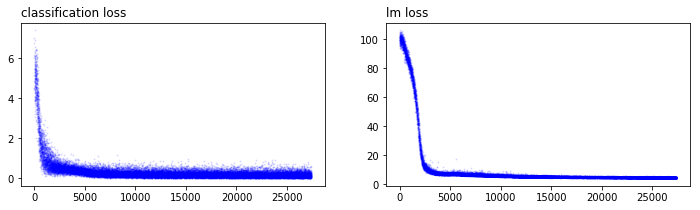

In [0]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 2, 1)
plt.plot(clf_losses, 'o', color='b', ms=1, alpha=0.1)
plt.title('classification loss', fontsize=12, loc='left')
ax = fig.add_subplot(1, 2, 2)
plt.plot(lm_losses, 'o', color='b', ms=1, alpha=0.1)
plt.title('lm loss', fontsize=12, loc='left');

#### Encode eval data

In [0]:
val_seqs = encode(val_texts,
                  val_labels,
                  tokenizer,
                  MAX_LEN,
                  SPECIAL_TOKENS)

val_ds = TensorDataset(*val_seqs)
val_sampler = SequentialSampler(val_ds)

val_loader = DataLoader(val_ds,
                        sampler=val_sampler,
                        batch_size=BATCH_SIZE)

100%|██████████| 158423/158423 [00:42<00:00, 3719.59it/s]


#### Load trained model
Skip this step if training and evaluating in the same runtime.

In [0]:
SAVED_MODEL_FNAME = 'gpt2_117M_pytorch.bin'
SAVED_MODEL_DIR = '/content/saved_models'
model.load_state_dict(torch.load(os.path.join(SAVED_MODEL_DIR, SAVED_MODEL_FNAME)))
logger1.info(f'Model loaded from {SAVED_MODEL_DIR + "/" + SAVED_MODEL_FNAME}')

#### Inference

In [0]:
model = model.to(device)

model.eval()

val_logits = []
val_preds = []

tq = tqdm(enumerate(val_loader), total=len(val_loader), mininterval=10)
for i, batch in tq:
    input_ids, mc_token_ids, _, _ = batch
    
    _, mc_logits_batch, _ = model(input_ids.to(device),
                                  mc_token_ids.to(device))
    
    preds_batch = torch.sigmoid(mc_logits_batch).to(device)
    preds_batch = preds_batch.detach().cpu().squeeze().tolist()
    
    val_preds.extend(preds_batch)

100%|██████████| 19803/19803 [36:51<00:00,  8.95it/s]


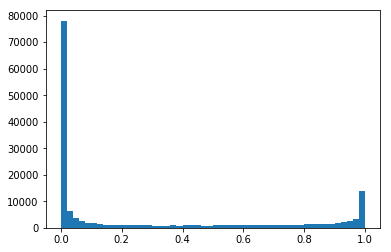

In [0]:
plt.hist(val_preds, bins=50);

#### Eval metrics

In [0]:
val_preds = np.array(val_preds)
val_AUC = metrics.roc_auc_score(val_labels, val_preds)
val_acc = metrics.accuracy_score(val_labels.astype('int'), val_preds.astype('int'))
logger1.info(f'Eval set AUC = {val_AUC:.4f}')
logger1.info(f'Eval set accuracy = {val_acc:.4f}')
print(f'AUC {val_AUC:.4f}, acc {val_acc:.4f}')

AUC 0.9673, acc 0.7467
